In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
from parameters import *
from micro import *
from chem import *
from aero_init import *
from parcel import *
from condensation import *
from collision import *
from analysis import *
from print_plot import *

import itertools
import matplotlib

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intialization
## Input parameter

In [3]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create the widgets for the variables
var1_widget = widgets.FloatText(description='dt:')
var2_widget = widgets.IntText(description='nt:')
var3_widget = widgets.IntSlider(description='N_aero1:', min=0, max=500, value=100)
var4_widget = widgets.IntSlider(description='N_aero2:', min=0, max=500, value=50)
var5_widget = widgets.Checkbox(description='Condensation:', value=False)
var6_widget = widgets.Checkbox(description='Collision:', value=False)

# Define a function to be called when the user clicks the button
"""
def set_variables(button):
    var1 = var1_widget.value
    var2 = var2_widget.value
    var3 = var3_widget.value
    var4 = var4_widget.value
    
    clear_output()
    
    print(f'Variable 1: {var1}')
    print(f'Variable 2: {var2}')
    print(f'Variable 3: {var3}')
    print(f'Variable 4: {var4}')
"""

# Create a button widget
#button = widgets.Button(description='Set Variables')

# Attach the button click event to the function
#button.on_click(set_variables)

# Display the widgets and button
display(var1_widget, var2_widget, var3_widget, var4_widget,var5_widget,var6_widget) #button)


FloatText(value=0.0, description='dt:')

IntText(value=0, description='nt:')

IntSlider(value=100, description='N_aero1:', max=500)

IntSlider(value=50, description='N_aero2:', max=500)

Checkbox(value=False, description='Condensation:')

Checkbox(value=False, description='Collision:')

In [7]:
n_ptcl = 1000

dt = 0.5 #var1_widget.value #0.5
nt = 7200 #var2_widget.value #100

do_condensation = True #var4_widget.value  #True
do_collision    = False #var5_widget.value  #False

#parcel info. 
T_parcel   = 293.2 
P_parcel   = 1013.0E2
q_parcel   = 8.0E-3
RH_parcel  = 0.88
w_parcel   = 0.5 # m/s
z_parcel   = 0.0 #m

max_z = 3600. 

#aerosol initialization
N_aero = [1e6*var3_widget.value,1e6*var4_widget.value  ]#[100.0E6, 50.0E6]
mu_aero = [np.log(100.0E-9), np.log(500.0E-9)]
sigma_aero = [np.log(2), np.log(2)]
rho_aero = 2170.0
molecular_weight_aero = 0.058443

n_particles_mode1 = n_ptcl // 2  # Number of particles for the first mode
n_particles_mode2 = n_ptcl - n_particles_mode1  # Number of particles for the second mode

# Generate log-normal distribution for the first mode
mode1_values = np.random.lognormal(mu_aero[0], sigma_aero[0], n_particles_mode1)

# Generate log-normal distribution for the second mode
mode2_values = np.random.lognormal(mu_aero[1], sigma_aero[1], n_particles_mode2)

# Combine the values from both modes
aero_r_seed = np.concatenate((mode1_values, mode2_values))

nbins = 100
log_edges = np.logspace(np.log10(0.1E-6), np.log10(200.0E-6), nbins + 1)
spectra_arr = np.zeros((nt+1,nbins))

# Time step routine

In [ ]:
dz=0
z_parcel, T_parcel, rho_parcel, V_parcel, air_mass_parcel = ascend_parcel(z_parcel, T_parcel,P_parcel, dz)
#Aerosol init
T_parcel, q_parcel, particles_list = aero_init( n_ptcl, P_parcel, T_parcel,q_parcel, aero_r_seed,N_aero,rho_aero,molecular_weight_aero)
#parcel routine
spectra_arr[0],qa, qc,qr, na, nc, nr = qc_qr_analysis(particles_list,air_mass_parcel,log_edges)

#fig, ax = plt.subplots()
for t in range(nt):
    
    #Parcel ascending
    dz = w_parcel * dt
    if z_parcel < max_z: 
        z_parcel, T_parcel, rho_parcel, V_parcel, air_mass_parcel = ascend_parcel(z_parcel, T_parcel,P_parcel, dz)
    
    #Condensational Growth
    dq_liq = 0.0
    if do_condensation:
        particles_list, T_parcel, q_parcel = drop_condensation(particles_list, T_parcel, q_parcel, P_parcel, dt, air_mass_parcel, rho_aero, molecular_weight_aero)

    #Collisional Growth
    if do_collision:
        particles_list = collection(dt, particles_list,rho_parcel, rho_liq, P_parcel, T_parcel)
    #Analysis
    spectra_arr[t+1],qa, qc,qr, na, nc, nr = qc_qr_analysis(particles_list,air_mass_parcel,log_edges)
    
    #Visulaization
    print_output(t,dt, z_parcel, T_parcel, q_parcel, qa, qc, qr, na, nc, nr)
    #spec_plot(ax,spectra_arr, nt, log_edges)
    

value: Time (s)  z (m)    T (K)    qv (g/kg) QA       QC (g/kg) QR (g/kg) NA       NC       NR      
after: 569.5     284.50   290.42   8.00      0.00     0.00     0.00     82.10    17.90    0.00    


/project/meteo/work/J.Lim/PyLCM_parcel/print_plot.py:22: UserWarning: Log scale: values of z <= 0 have been masked
  contour = ax.contourf(np.arange(nt+1), log_edges[1:], spectra_arr.T, norm=matplotlib.colors.LogNorm())


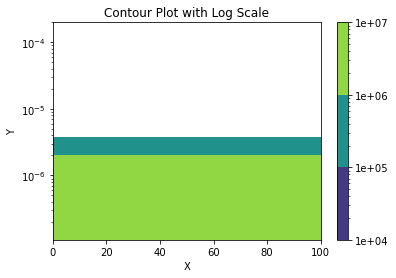

In [6]:
fig, ax = plt.subplots()
spec_plot(ax,spectra_arr, nt, log_edges)